In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree as tree
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')  
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Wrangling

The last time, I completely deleted a couple of columns, and attempted to fill the rows in which the Age was missing. A different approach will be attempted this time, I'll include both SibSp and Parch columns, and the age too. For now, I will completely drop the rows in which Age is missing.

Let's begin with building the Data Frame, but I'll join SibSp and Parch columns into one, named 'Family', which will indicate how many family members related to the passenger were on the ship, and I will concatenate it into the main Data Frame.

In [3]:
Family = train_data['SibSp'] + train_data['Parch']
df = train_data[['Survived', 'Pclass', 'Sex', 'Age']]
fam = pd.Series(Family)
fam = fam.rename('Family')
df = pd.concat([df, fam], axis=1)
df.head()


,Survived,Pclass,Sex,Age,Family
0,0,3,male,22.0,1
1,1,1,female,38.0,1
2,1,3,female,26.0,0
3,1,1,female,35.0,1
4,0,3,male,35.0,0


Now, let's check for missing values.

In [4]:
pd.isna(df).sum()

Survived      0
Pclass        0
Sex           0
Age         177
Family        0
dtype: int64

177 rows are missing from the Age column. For this attempt, let's drop all the rows that contain missing data.

In [5]:
df.fillna(df['Age'].mean(), inplace=True)
pd.isna(df).sum()

Survived    0
Pclass      0
Sex         0
Age         0
Family      0
dtype: int64

The Sex column is still categorical, we'll change it to a binary column, since the only options are 'male' or 'female'.

In [6]:
df['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Family
0,0,3,0,22.0,1
1,1,1,1,38.0,1
2,1,3,1,26.0,0
3,1,1,1,35.0,1
4,0,3,0,35.0,0


Running now the correlation matrix, graphically producing a heatmap:

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Survived'),
  Text(1.5, 0, 'Pclass'),
  Text(2.5, 0, 'Sex'),
  Text(3.5, 0, 'Age'),
  Text(4.5, 0, 'Family')])

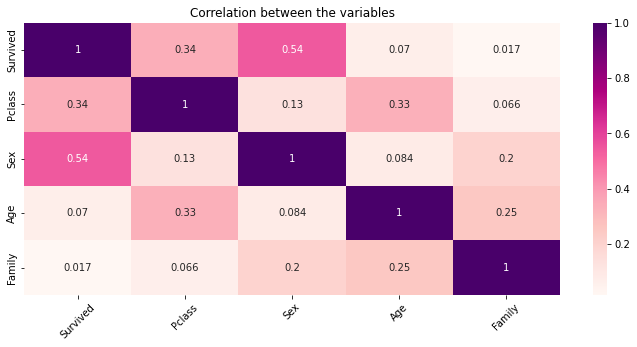

In [7]:
#correlation matrix and the heatmap
plt.subplots(figsize=(12,5))
correlation=abs(df.corr())
sns.heatmap(correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

It is obvious the strongest correlations are Sex and Pclass. Age and Family barely contribute anything to the correlation matrix, but let's keep them for now.

It's also noticeable that some random attributes are randomly slightly correlated, like Age and Pclass, or Age and Family. While it would be wise to try and combine them, like I did with SibSp and Parch, I can't find an angle to simply do so.

Let's split the Data Frame into attributes and the target variable, while normalizing the attributes values.

In [8]:
y_train = df['Survived'].values
y_train[0:5]

array([0, 1, 1, 1, 0])

In [9]:
X_train = df.drop(['Survived'], axis=1)
X_train =  preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:5]

array([[ 0.82737724, -0.73769513, -0.5924806 ,  0.05915988],
       [-1.56610693,  1.35557354,  0.63878901,  0.05915988],
       [ 0.82737724,  1.35557354, -0.2846632 , -0.56097483],
       [-1.56610693,  1.35557354,  0.40792596,  0.05915988],
       [ 0.82737724, -0.73769513,  0.40792596, -0.56097483]])

# Machine Learning
Now that we have our data filtered and cleaned, it's time to apply some machine learning modeling, and try to get the best possible accuracy. I'm no expert in Machine Learning, so I'll stick to four different Classification algorithms, k-Nearest Neighbor, Decision Tree, SVM and Logistic Regression. For each method, a Grid Search method will be applied, to find the best parameters for each of the algorithms. The accuracy will be measured by the Grid Search method.

## k-Nearest Neighbor
Let's define a range of k-values from 1 to 30, and let the Grid Search methodology find the best one.

In [10]:
k_range=list(range(1,30))
param_knn=dict(n_neighbors = k_range, algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'])
knn_cv=GridSearchCV(KNeighborsClassifier(), param_knn, cv=10, scoring='accuracy')
knn_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 4}
accuracy : 0.8295255930087391


With the results from the gridsearch, we can conclude the best k-value is 4, with a Brute-force search algorithm. Let's do a new fit with this parameter, knowing the maximum accuracy is 83.5%.

In [11]:
knn=KNeighborsClassifier(n_neighbors=5, algorithm='brute')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute')

## Decision Tree
As the Decision Tree has quite an amount of adjustable parameters, we'll stick to 3 of these: criterion, splitter and max_depth.

In [12]:
param_tree={'criterion':['gini', 'entropy'], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150], 'splitter':['best', 'random']}
tree_cv=GridSearchCV(DecisionTreeClassifier(), param_tree, cv=10, scoring='accuracy')
tree_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
accuracy : 0.8260299625468164


The results of the Grid Search retrieve a criterion of 'gini', a max_depth of 8, and a 'random' splitter. We already know the best accuracy of this model should be 81.8%, lower than the KNN model.

In [13]:
tree=DecisionTreeClassifier(criterion='gini', max_depth=8, splitter='random')
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, splitter='random')

## SVM
SVM models also have a quite lenghty list of parameters. I'll stick to calculating the C parameter, the kernel and the gamma values.

PS: calculating the 'kernel' parameter takes a lot of computational power, due to time constraints I will leave it as 'rbf'.

In [14]:
param_svm={'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
svm_cv=GridSearchCV(SVC(), param_svm, cv=10, scoring='accuracy')
svm_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
accuracy : 0.8316354556803995


The results provide an optimal C of 10 and a gamma of 0.1.
Thus, the accuracy is of 0.82, so KNN's accuracy is still higher.

In [15]:
svm=SVC(C=10, gamma=0.1, kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

## Logistic Regression
Finally, the last algorithm. Again, a lot of changeable parameters, I'll stick to optimizing C, and the penalty, either 'l1' or 'l2', as 'elastic' or 'none' bring up too many complications. In order to accept either kind penalty, the solver will be set to 'liblinear'.

In [16]:
param_logreg={'C': [0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}
logreg_cv=GridSearchCV(LogisticRegression(), param_logreg, cv=10, scoring='accuracy')
logreg_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.7957178526841449


Our worst result so far, perhaps due to the inflexibility of the hyper parameters, an accuracy of 79.4%. The better parameters were a C value of 1, and an 'l1' penalty.

In [17]:
logreg=LogisticRegression(C=1, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

# Conclusion
kNN model was the best, not for a huge gap, but still the best. Thus, let's predict the survivability with the obtained model, and upload the results to Kaggle. Let's do to the Train Data what we did to the Test data, first.

In [18]:
#Creating the Family column
Family = test_data['SibSp'] + test_data['Parch']

#Creating the main Data Frame
df = test_data[['Pclass', 'Sex', 'Age']]

#Concatenating the family column to the main data frame
fam = pd.Series(Family)
fam = fam.rename('Family')
df = pd.concat([df, fam], axis=1)

#Changing the Sex column from categorical to binary
df['Sex'].replace(to_replace=['male','female'], value=[0,1], inplace=True)

#Dropping the rows in which Age is missing
df.fillna(df['Age'].mean(), inplace=True)

#Normalizing the attributes
X_test = df
X_test =  preprocessing.StandardScaler().fit(X_test).transform(X_test)

#Predicting with the model
yhat=knn.predict(X_test)

#Treating the yhat column, to concatenate with the PassengerId column
yhat=pd.Series(data=yhat)
yhat=yhat.rename('Survived')
result=pd.concat([test_data['PassengerId'], yhat], axis=1)
result.to_csv('/kaggle/working/result.csv', index=False)